In [5]:
import zipfile
import os

# Zip dosyasının bulunduğu dizin
zip_file_path = '/content/CaltechTinyThreeClass.zip'  # Colab'de upload ettiğiniz dosyanın yolu
extraction_path = '/content/CaltechTinyThreeClass/'  # Zip dosyasını çıkartacağınız dizin

# Zip dosyasını çıkartma
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Çıkartılan dosyaların yolunu kontrol etme
extracted_files = os.listdir(extraction_path)
print(extracted_files)


['CaltechTinyThreeClass']


In [6]:
# Let's explore the contents of the extracted folder
folder_path = os.path.join(extraction_path, 'CaltechTinyThreeClass')
subfolders = os.listdir(folder_path)
subfolders


['test', 'train']

In [72]:
import os
import cv2
import numpy as np

# Eğitim verilerinin yolunu belirleme
train_folder = os.path.join(folder_path, 'train')
classes = ['camera', 'flamingo', 'pizza']

# Görüntüleri oku ve özellikleri çıkar
x_train = []
y_train = []

def calculate_statistical_features(image_vector):
    N = len(image_vector)
    mean_val = np.mean(image_vector)

    # Skewness Factor
    skewness = (1/N) * np.sum((image_vector - mean_val)**3) / (np.sqrt((1/N) * np.sum((image_vector - mean_val)**2))**3)

    # Kurtosis Factor
    kurtosis = (1/N) * np.sum((image_vector - mean_val)**4) / (np.sqrt((1/N) * np.sum((image_vector - mean_val)**2))**4)

    # Crest Factor
    crest_factor = np.max(np.abs(image_vector)) / np.sqrt((1/N) * np.sum(image_vector**2))

    # Shape Factor
    shape_factor = np.sqrt((1/N) * np.sum(image_vector**2)) / ((1/N) * np.sum(np.abs(image_vector)))

    # Impulse Factor
    impulse_factor = np.max(np.abs(image_vector)) / ((1/N) * np.sum(np.abs(image_vector)))

    # Margin Factor
    margin_factor = np.max(np.abs(image_vector)) / np.sqrt((1/N) * np.sum(np.sqrt(np.abs(image_vector)))**2)

    return [skewness, kurtosis, crest_factor, shape_factor, impulse_factor, margin_factor]

def extract_features(image):
    # Görüntüyü gri tonlamaya çevir ve 128x128 boyutuna indir
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray_image, (128, 128))

    # Görüntünün türevini al
    sobelx = cv2.Sobel(resized_image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(resized_image, cv2.CV_64F, 0, 1, ksize=5)
    gradient = np.hypot(sobelx, sobely).flatten()

    # 6 istatistiksel özelliği çıkar
    features = calculate_statistical_features(gradient)

    return features

# Her sınıftaki görüntüleri işle
for class_index, class_name in enumerate(classes, 1):
    class_folder = os.path.join(train_folder, class_name)
    for image_name in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            features = extract_features(image)
            x_train.append(features)
            y_train.append(class_index)

# Eğitim verilerini numpy array'e çevir
x_train = np.array(x_train)
y_train = np.array(y_train)

print("Eğitim verileri başarıyla işlendi.")


Eğitim verileri başarıyla işlendi.


Genel Accuracy (Doğruluk): 78.95%
Camera Accuracy (Doğruluk): 80.00%
Flamingo Accuracy (Doğruluk): 87.50%
Pizza Accuracy (Doğruluk): 66.67%
Rastgele Seçilen Test Görselinin Sınıfı: flamingo (2)
Tahmin Edilen Sınıf: flamingo (2)


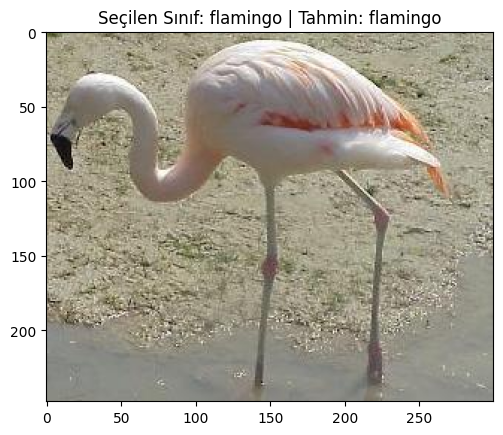

In [129]:
import random
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# KNN fonksiyonunu tanımlama
def KNN(x_train, y_train, sample_test, k=5):
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(x_train, y_train)  # Eğitim verisi ile modeli eğit
    predicted_label = knn.predict([sample_test])  # Tahmin edilen sınıf etiketi (1, 2, 3)
    return predicted_label

# Test klasöründeki tüm sınıflar
test_folder = os.path.join(folder_path, 'test')
classes = ['camera', 'flamingo', 'pizza']

# Test klasörlerindeki tüm resimleri listeleme
test_images = []
test_labels = []
for class_index, class_name in enumerate(classes, 1):  # 1: camera, 2: flamingo, 3: pizza
    class_folder = os.path.join(test_folder, class_name)
    for image_name in os.listdir(class_folder):
        test_images.append((class_name, os.path.join(class_folder, image_name)))
        test_labels.append(class_index)  # Gerçek etiketler: 1, 2, 3

# Test verilerinden tahmin edilen etiketleri saklamak için liste
predicted_labels = []

# Her bir test görüntüsü için tahmin yap
for class_name, test_image_path in test_images:
    # Test görüntüsünü yükleyip özelliklerini çıkarma
    test_image = cv2.imread(test_image_path)
    sample_test = extract_features(test_image)  

    # KNN ile tahmini yap
    predicted_class = KNN(x_train, y_train, sample_test, k=5)
    predicted_labels.append(predicted_class[0])  # Tahmin edilen sınıfı kaydet

# Genel accuracy (doğruluk) hesaplama
overall_accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Genel Accuracy (Doğruluk): {overall_accuracy * 100:.2f}%")

# Her sınıf için ayrı accuracy hesaplama
for class_index, class_name in enumerate(classes, 1):
    class_test_labels = [label for label in test_labels if label == class_index]
    class_predicted_labels = [pred for i, pred in enumerate(predicted_labels) if test_labels[i] == class_index]

    class_accuracy = accuracy_score(class_test_labels, class_predicted_labels)
    print(f"{class_name.capitalize()} Accuracy (Doğruluk): {class_accuracy * 100:.2f}%")

# Rastgele bir test görüntüsünün seçilmesi ve görselleştirilmesi
selected_class, test_image_path = random.choice(test_images)

# Test görüntüsünün yüklenip özelliklerinin çıkarılması
test_image = cv2.imread(test_image_path)
sample_test = extract_features(test_image)  

# KNN ile tahmini yap
predicted_class = KNN(x_train, y_train, sample_test, k=5)

# Tahmin edilen sınıfı yazdır (1, 2, 3 etiketleriyle birlikte)
predicted_class_name = classes[predicted_class[0] - 1]  # Sınıf isimlerini döndürüyor
selected_class_index = classes.index(selected_class) + 1  # Seçilen sınıfın indeksini bul (1, 2, 3)

print(f"Rastgele Seçilen Test Görselinin Sınıfı: {selected_class} ({selected_class_index})")
print(f"Tahmin Edilen Sınıf: {predicted_class_name} ({predicted_class[0]})")

# Test görüntüsünü göster
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.title(f"Seçilen Sınıf: {selected_class} | Tahmin: {predicted_class_name}")
plt.axis('on')
plt.show()
